<a href="https://colab.research.google.com/github/Carolyn-Ha/MDST/blob/main/20_6_lec20_lenet_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook credit**: Based on the original D2L notebook [here](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/chapter_convolutional-neural-networks/lenet.ipynb).


# Convolutional Neural Networks (LeNet)

We now have all the ingredients required to assemble
a fully-functional CNN.
In our earlier encounter with image data,
we applied
a softmax regression model
and
an MLP model
to MNIST dataset.
To make such data amenable to softmax regression and MLPs,
we first flattened each image from a $28\times28$ matrix
into a fixed-length $784$-dimensional vector,
and thereafter processed them with fully-connected layers.
Now that we have a handle on convolutional layers,
we can retain the spatial structure in our images.
As an additional benefit of replacing fully-connected layers with convolutional layers,
we will enjoy more parsimonious models that require far fewer parameters.

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images.
This work represented the culmination
of a decade of research developing the technology.
In 1989, LeCun published the first study to successfully
train CNNs via backpropagation.


At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann and his colleague Leon Bottou wrote in the 1990s!




## LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully-connected layers**);
The architecture is summarized below.

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)


The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
these discoveries had not yet been made in the 1990s.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully-connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully-connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
hopefully the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers.


### ***Notes***
- can try to retain the spatial structure -> so that we can achieve a similar prediction accuracy but with much fewer parameters
  - convolutional layer: going to make use of the spatial structure -> use much fewer parameters in general than multi-layer perceptron and dense NN
- core difference between convolutional NN & dense NN: we're going to have additional convoltional layer closer to the input
  - in the later layer: rely on dense layer when we have prediction, classification task
  - earlier layer(when closer to input): rely more on the convolutional layer
- map spatially arrange inputs into a number of 2-dimensional feature maps, increasing the number of channels
  - as we build general convolutional layers: going to have lower and lower spatial dimensions

- Lenet: 3 fully connected layers -> perform classification
  - as we go up: the number of channel is going to increase -> but at every single pooling layer, they're going to have the heightened width
  - as the number of layers increase -> the number of channels will increase(number of spatial dimensionality is going to decrease)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

We took a small liberty with the original model,
removing the Gaussian activation in the final layer.
Other than that, this network matches
the original LeNet-5 architecture.

By passing a single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to make sure
that its operations line up with
what we expect from the figure above.

![Compressed notation for LeNet-5.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/lenet-vert.svg?raw=1)


Note that the height and width of the representation
at each layer throughout the convolutional block
is reduced (compared with the previous layer).
The first convolutional layer uses 2 pixels of padding
to compensate for the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.
In contrast, the second convolutional layer forgoes padding,
and thus the height and width are both reduced by 4 pixels.
As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second convolutional layer.
However, each pooling layer halves the height and width.
Finally, each fully-connected layer reduces dimensionality,
finally emitting an output whose dimension
matches the number of classes.



## Training

Now that we have implemented the model,
let us [**run an experiment to see how LeNet fares on Fashion-MNIST**].


In [ ]:
batch_size = 256
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  #(1) downloading the training data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

While CNNs have fewer parameters,
they can still be more expensive to compute
than similarly deep MLPs
because each parameter participates in many more
multiplications.
**If you have access to a GPU, this might be a good time
to put it into action to speed up training.**

[**Now let us train and evaluate the LeNet-5 model.**]


In [ ]:
num_epochs = 20

model = keras.Sequential([
    layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                  padding='same', input_shape=(28, 28, 1)),
                  #(1) output size = input size -> specifically mention the input size
    layers.AvgPool2D(pool_size=2, strides=2),
    layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'),
                  #(2) change the filter size(increase)
    layers.AvgPool2D(pool_size=2, strides=2),
    layers.Flatten(),
      #(3) when moving from convolutional NN -> dense NN: need to flatten & destroy the spatial structure
    layers.Dense(120, activation='sigmoid'),
    layers.Dense(84, activation='sigmoid'),
    layers.Dense(10, activation='softmax')
      #(4) since we are doing classification, last layer's activation function should be 'softmax'
        # - apply activation function to every single output of the convolutional layer
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
  #(1) element-wise operation
  #(2) check whether the training loss is going down (validation loss could fluctuate a little)

Epoch 1/20
188/188 [==============================] - 13s 8ms/step - loss: 1.9590 - accuracy: 0.2934 - val_loss: 1.2270 - val_accuracy: 0.5527
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 1.0105 - accuracy: 0.6358 - val_loss: 0.8809 - val_accuracy: 0.6703
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.8289 - accuracy: 0.6933 - val_loss: 0.7806 - val_accuracy: 0.7169
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.7494 - accuracy: 0.7181 - val_loss: 0.7096 - val_accuracy: 0.7307
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.6972 - accuracy: 0.7304 - val_loss: 0.6696 - val_accuracy: 0.7346
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.6629 - accuracy: 0.7407 - val_loss: 0.6440 - val_accuracy: 0.7462
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.6384 - accuracy: 0.7507 - val_loss: 0.6304 - val_accuracy: 0.7582
Epoch

In [ ]:
model.summary()
  #(1) help us to calculate how many parameters we have
  #(2) dense layer: have much more parameters than convolutional layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

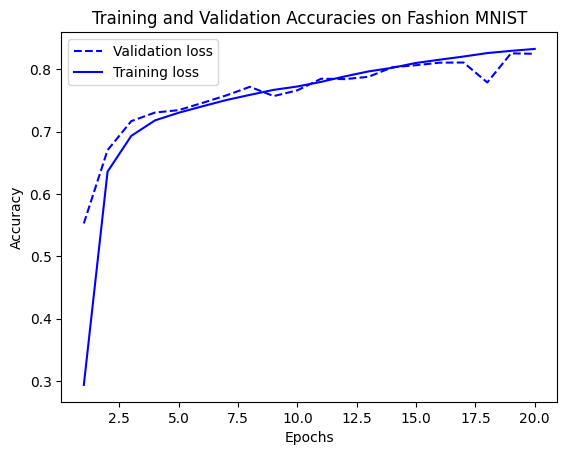

In [ ]:
import matplotlib.pyplot as plt

val_acc = history.history["val_accuracy"]
acc = history.history["accuracy"]
epochs = range(1, 21)
plt.plot(epochs, val_acc, "b--",
         label="Validation loss")
plt.plot(epochs, acc, "b",
         label="Training loss")
plt.title("Training and Validation Accuracies on Fashion MNIST")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.4870 - accuracy: 0.8191


[0.4870235323905945, 0.819100022315979]

## Function API

We have only used the Sequential API in Keras to build deep learning model. However, there are two more choices:

- Functional API
- Model subclassing

Let's look at each of them to redo the LeNet example above. If your architecture is not just a simple linear sequence of layers, you cannot use the Sequential API. A common use case is **residual connections**. For example, see this [toy ResNet model](https://keras.io/guides/functional_api/#a-toy-resnet-model).

In [ ]:
# model = keras.Sequential([
#     layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
#                   padding='same', input_shape=(28, 28, 1)),
#     layers.AvgPool2D(pool_size=2, strides=2),
#     layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'),
#     layers.AvgPool2D(pool_size=2, strides=2),
#     layers.Flatten(),
#     layers.Dense(120, activation='sigmoid'),
#     layers.Dense(84, activation='sigmoid'),
#     layers.Dense(10, activation='softmax')
# ])


In [ ]:
inputs = keras.Input(shape=(28,28,1))
  #(1) define input & operation as functions

conv1 = layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same')
x = conv1(inputs)
  #(2) defining the output x

pool1 = layers.AvgPool2D(pool_size=2, strides=2)
x = pool1(x)
  #(3) giving the new output

conv2 = layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid')
x = conv2(x)

pool2 = layers.AvgPool2D(pool_size=2, strides=2)
x = pool2(x)

flatten = layers.Flatten()
x = flatten(x)

fc1 = layers.Dense(120, activation='sigmoid')
x = fc1(x)

fc2 = layers.Dense(84, activation='sigmoid')
x = fc2(x)

fc3 = layers.Dense(10, activation='softmax')
outputs = fc3(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="LeNet_model")

In [ ]:
model.summary()

Model: "LeNet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 400)               

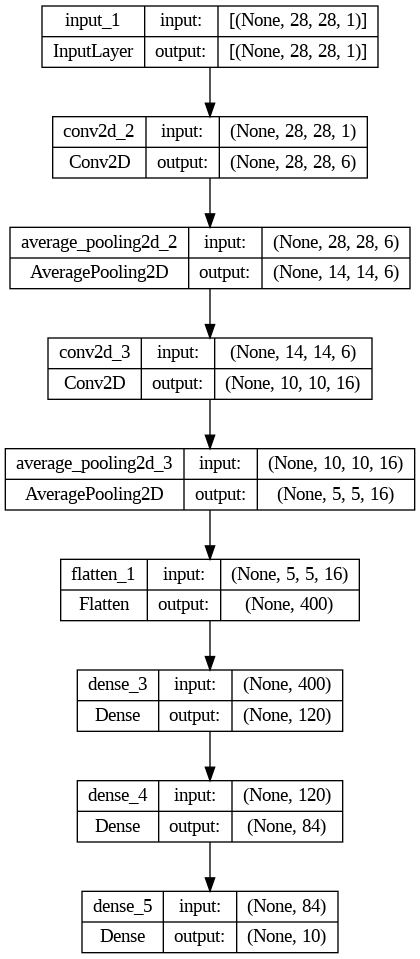

In [ ]:
keras.utils.plot_model(model, show_shapes=True)
  #(1) output for every single layer I've specified -> visualize everything

Model fitting works exactly the same as with sequential API.

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
188/188 [==============================] - 2s 7ms/step - loss: 2.1387 - accuracy: 0.2225 - val_loss: 1.4914 - val_accuracy: 0.5228
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 1.1285 - accuracy: 0.5988 - val_loss: 0.9326 - val_accuracy: 0.6749
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.8590 - accuracy: 0.6848 - val_loss: 0.7977 - val_accuracy: 0.7050
Epoch 4/20
188/188 [==============================] - 1s 8ms/step - loss: 0.7620 - accuracy: 0.7155 - val_loss: 0.7134 - val_accuracy: 0.7350
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.7068 - accuracy: 0.7292 - val_loss: 0.6782 - val_accuracy: 0.7408
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.6719 - accuracy: 0.7402 - val_loss: 0.6629 - val_accuracy: 0.7322
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.6452 - accuracy: 0.7504 - val_loss: 0.6160 - val_accuracy: 0.7574
Epoch 

## Model Subclassing

In [ ]:
class LeNet_Model(keras.Model):
    #(1) can absorb all the code into a class: so that we can automatically invoke the Lynette model
      # - thus whenever we call the Lynette model: it will do the same operation

  def __init__(self, num_classes, input_shape):
    super(LeNet_Model, self).__init__()

    self.conv1 = layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same', input_shape=input_shape)
    self.pool1 = layers.AvgPool2D(pool_size=2, strides=2)
    self.conv2 = layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid')
    self.pool2 = layers.AvgPool2D(pool_size=2, strides=2)
    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(120, activation='sigmoid')
    self.fc2 = layers.Dense(84, activation='sigmoid')
    self.fc3 = layers.Dense(num_classes, activation='softmax')

  def call(self, inputs):
      #(1) subsuming every single thing into this class
    x = self.conv1(inputs)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    outputs = self.fc3(x)
    return outputs

In [ ]:
lenet_model = LeNet_Model(10, (None, 28, 28, 1))
lenet_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
x_train = tf.expand_dims(x_train, -1)
x_train.shape

TensorShape([60000, 28, 28, 1])

In [ ]:
history = lenet_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 1.9683 - accuracy: 0.2964 - val_loss: 1.2294 - val_accuracy: 0.5786
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.9883 - accuracy: 0.6466 - val_loss: 0.8335 - val_accuracy: 0.7057
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.8037 - accuracy: 0.7045 - val_loss: 0.7430 - val_accuracy: 0.7221
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.7281 - accuracy: 0.7236 - val_loss: 0.6909 - val_accuracy: 0.7410
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.6841 - accuracy: 0.7358 - val_loss: 0.6652 - val_accuracy: 0.7352
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.6560 - accuracy: 0.7458 - val_loss: 0.6546 - val_accuracy: 0.7395
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.6335 - accuracy: 0.7559 - val_loss: 0.6176 - val_accuracy: 0.7626
Epoch 

## Summary

* A CNN is a network that employs convolutional layers.
* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.
* In a CNN, convolutional layers are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.
* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output.
* LeNet was arguably the first successful deployment of such a network
* In Keras, we can build models using the Sequential API, the Functional API, or Model Subclassing
